In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Загружаем датасет
retail = pd.read_excel(r'J:\Загрузки\Online Retail.xlsx')

In [3]:
#Получим информацию о содержимом полей
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
retail['Description'] = retail['Description'].fillna('unknown')
retail = retail.dropna(subset=['CustomerID'])

In [5]:
retail.duplicated().sum()

5225

In [6]:
#Удалим строчки-дубликаты
retail.drop_duplicates(inplace=True)

In [7]:
#Проверим числовые поля на релевантность содержимого
retail.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [8]:
# Каким-то образом в данные попали продажи отрицательного количества товара и по отрицательной цене. Уберём из датасета строки с такой инфой
retail = retail[(retail['Quantity']>0) & (retail['UnitPrice'] > 0)]

In [9]:
# Напишем функцию, которая позволяет получить месяц из даты и с её помощью создадим поле, которое будет содержать для каждой продажи месяц, когда
#она была совершена
def get_month(x):
    return dt.datetime(x.year, x.month,1)

retail['InvoiceMonth'] = retail['InvoiceDate'].apply(get_month)

In [12]:
# Создадим ещё одно поле, которое будет содержать когорту покупателя, а именно - месяц совершения им первой покупки

retail['CohortMonth'] = retail.groupby('CustomerID')['InvoiceMonth'].transform('min')

In [13]:
# Для каждой когорты нам надо построить "lifespan" ("время жизни"), это разница между "стартом" когорты и периодом каждой продажи.
# Мы будем измерять lifespan в месяцах. У нас задействованы два года, поэтому для того, чтобы не было путаницы, придётся учесть смену не только месяцев
# но и лет.
def get_month_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

invoice_year, invoice_month,_ = get_month_int(retail, 'InvoiceMonth')
cohort_year, cohort_month,_ = get_month_int(retail, 'CohortMonth')

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month
retail['Lifespan'] = year_diff * 12 + month_diff + 1

In [18]:
# Посчитаем, количество покупателей из каждой когорты, которые достигли каждого конкретного "времени жизни"
c_table = retail.groupby(['CohortMonth', 'Lifespan'])['CustomerID'].nunique()
c_table

CohortMonth  Lifespan
2010-12-01   1           885
             2           324
             3           286
             4           340
             5           321
                        ... 
2011-10-01   2            86
             3            41
2011-11-01   1           323
             2            36
2011-12-01   1            41
Name: CustomerID, Length: 91, dtype: int64

In [19]:
# Превратим нашу таблицу в плоскую, чтобы проще было построить из неё сводную
c_table = c_table.reset_index()
c_table

,CohortMonth,Lifespan,CustomerID
0,2010-12-01,1,885
1,2010-12-01,2,324
2,2010-12-01,3,286
3,2010-12-01,4,340
4,2010-12-01,5,321
...,...,...,...
86,2011-10-01,2,86
87,2011-10-01,3,41
88,2011-11-01,1,323
89,2011-11-01,2,36


In [21]:
# А теперь построим сводную!
c_counts = c_table.pivot_table(index='CohortMonth', columns='Lifespan', values='CustomerID')
c_counts

Lifespan,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Мы получили ОЧЕНЬ ценную таблицу, содержащую статистику того, сколько уникальных покупателей покупали на каждом периоде "времени жизни" своей когорты.
# Теперь-то мы можем получать такие важные показатели как retention, churn rate и др.
# Вот retention

initialy_c_volume = c_counts.iloc[:,0]
retention = c_counts.divide(initialy_c_volume, axis=0)
retention =  retention.round(3)*100

<Axes: title={'center': 'CUSTOMERS RETENTION (%)'}, xlabel='Lifespan', ylabel='CohortMonth'>

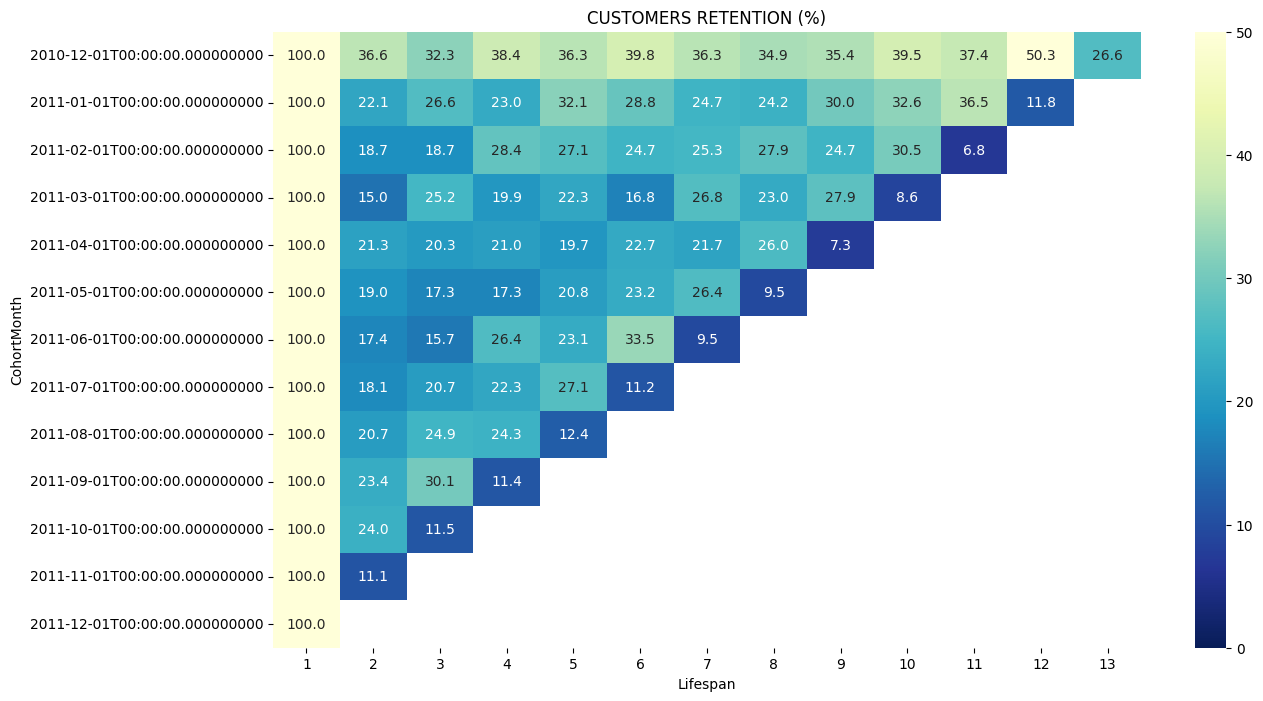

In [42]:
# Для наглядности построим тепловую карту

plt.figure(figsize=(14,8))
plt.title('CUSTOMERS RETENTION (%)')
sns.heatmap(data=retention, cmap='YlGnBu_r', vmin=0, vmax=50, fmt = '.1f', annot=True)